# Comparing a USGSCSM and ISIS camera for Dejittered HiRISE image

In [1]:
import pyproj
import pvl
import numpy as np
import os
import pandas as pd
import json
from IPython.display import Image

os.environ['ISISROOT'] = '/Users/jmapel/miniconda3/envs/local_3_7_0_RC_2'
import knoten
from knoten import vis
import csmapi
from ale.drivers.isis_ideal_drivers import IdealLsIsisLabelIsisSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from pysis import isis
from pysis.exceptions import ProcessError

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Update the ISIS cube
Requires ESP_016076_2175_REDmos_hijitreged.balance.noproj.8bit.cub in data directory

We also have to set the shapemodel to the ellipsoid because CSM does not natively support DEM intersections

In [2]:
cub_loc = 'data/ESP_016076_2175_REDmos_hijitreged.balance.noproj.8bit.cub'
try:
    isis.editlab(from_=cub_loc, grpname='Kernels', Keyword='ShapeModel', value='Null')
except ProcessError as e:
    print(f'Failed to set shapemodel for {cub_loc} to ellipsoid:\n{e.stderr}')

## Generate a USGSCSM ISD

In [3]:
with IdealLsIsisLabelIsisSpiceDriver(cub_loc) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)
    
    csm_isd = os.path.splitext(cub_loc)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))

## Compare the Exterior Orientations

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

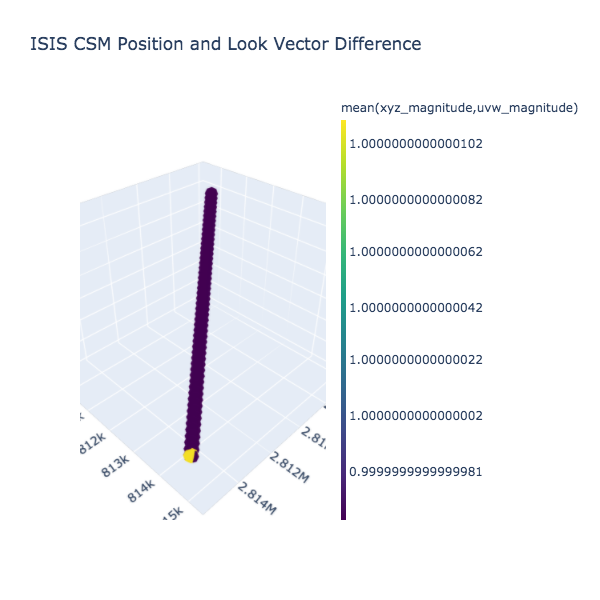

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

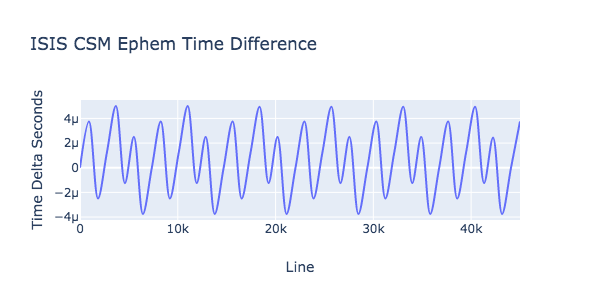

In [6]:
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_ephem_plot_bytes)

In [12]:
external_orientation_data.describe()

,isis pos x,isis pos y,isis pos z,csm lv x,csm lv y,csm lv z,isis lv x,isis lv y,isis lv z,diffx,diffy,diffz,diffu,diffv,diffw,xyz_magnitude,uvw_magnitude,isis ephem time,csm ephem time,diff ephem
count,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,2.810832e+06,812348.029736,2.234689e+06,-0.708145,-0.340549,-0.618484,-0.708145,-0.340549,-0.618484,0.000020,0.000010,-0.000029,-5.337538e-12,-2.927693e-12,7.725519e-12,6.826144e-05,1.817342e-11,3.155035e+08,3.155035e+08,6.699562e-07
std,2.275241e+03,1171.310993,3.327603e+03,0.002613,0.005171,0.000880,0.002613,0.005171,0.000880,0.000041,0.000021,0.000060,1.093834e-11,5.988350e-12,1.582113e-11,4.922560e-05,1.310797e-11,1.227762e+00,1.227762e+00,2.840488e-06
min,2.806970e+06,810360.820818,2.229042e+06,-0.713136,-0.349173,-0.620064,-0.713136,-0.349173,-0.620064,-0.000055,-0.000028,-0.000152,-2.765910e-11,-1.486278e-11,-2.125011e-11,4.667311e-08,3.436315e-15,3.155035e+08,3.155035e+08,-3.755093e-06
25%,2.808864e+06,811334.536932,2.231809e+06,-0.710348,-0.345034,-0.619244,-0.710348,-0.345034,-0.619244,-0.000007,-0.000003,-0.000071,-1.292411e-11,-7.009698e-12,-2.555983e-12,2.579966e-05,6.841396e-12,3.155035e+08,3.155035e+08,-1.251698e-06
50%,2.810834e+06,812348.351796,2.234690e+06,-0.708157,-0.340548,-0.618484,-0.708157,-0.340548,-0.618484,0.000021,0.000011,-0.000031,-5.552336e-12,-2.994716e-12,8.025802e-12,6.392260e-05,1.695410e-11,3.155035e+08,3.155035e+08,6.258488e-07
75%,2.812802e+06,813361.683406,2.237568e+06,-0.705942,-0.336072,-0.617725,-0.705942,-0.336072,-0.617725,0.000048,0.000025,0.000010,1.769973e-12,9.690027e-13,1.868747e-11,1.011408e-04,2.695312e-11,3.155035e+08,3.155035e+08,3.755093e-06
max,2.814688e+06,814334.025277,2.240330e+06,-0.703124,-0.331894,-0.616873,-0.703124,-0.331894,-0.616873,0.000103,0.000053,0.000081,1.472078e-11,8.187839e-12,3.994849e-11,1.912611e-04,5.081151e-11,3.155035e+08,3.155035e+08,5.006790e-06


## Compare the Ground Intersections and Back Projections

In [7]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

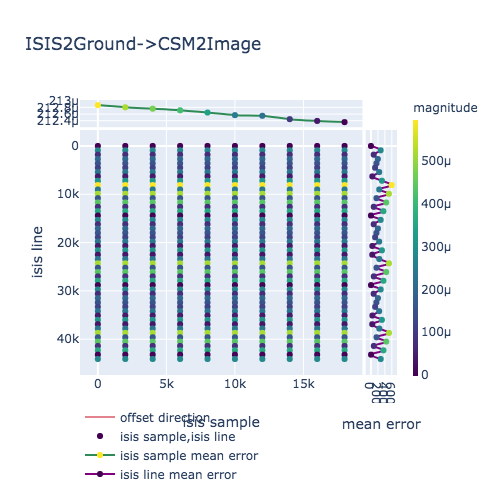

In [8]:
Image(isis2csm_plot.to_image())

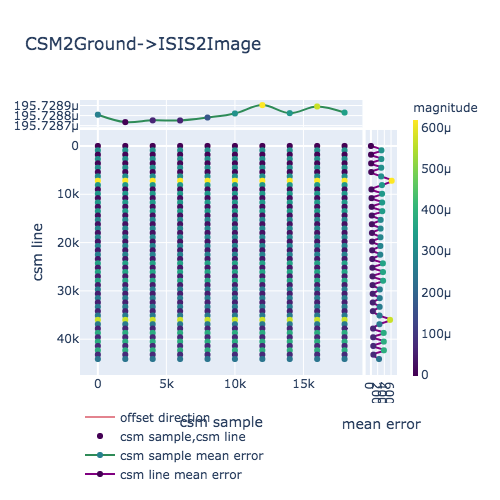

In [9]:
Image(csm2isis_plot.to_image())

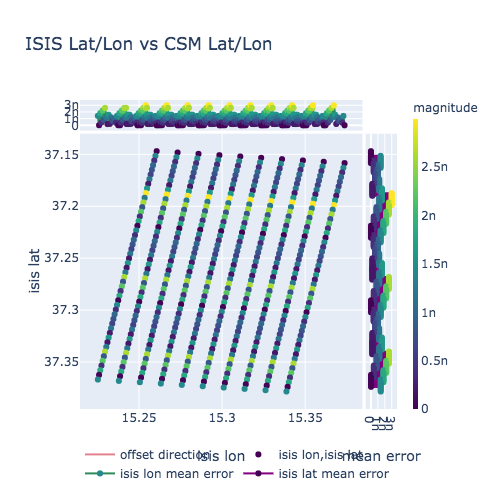

In [10]:
Image(isiscsm_plotlatlon.to_image())

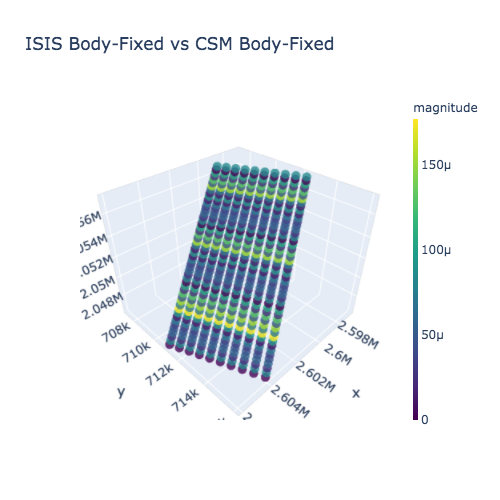

In [11]:
Image(isiscsm_plotbf.to_image())

In [13]:
isis2csm_data.describe()

,csm sample,csm line,isis sample,isis line,diff sample,diff line,magnitude,angles
count,5.000000e+02,5.000000e+02,500.00000,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000
mean,9.000000e+03,2.205000e+04,9000.00000,22050.000000,-3.015959e-08,-0.000115,2.126104e-04,-0.654834
std,5.750316e+03,1.300079e+04,5750.31584,13000.790018,1.288685e-07,0.000236,1.533363e-04,1.424089
min,-2.140641e-07,-1.716844e-07,0.00000,0.000000,-4.850808e-07,-0.000597,2.082644e-08,-1.703288
25%,4.000000e+03,1.080000e+04,4000.00000,10800.000000,-9.223095e-08,-0.000279,8.027639e-05,-1.571375
50%,9.000000e+03,2.205000e+04,9000.00000,22050.000000,-2.054139e-08,-0.000120,1.991631e-04,-1.570600
75%,1.400000e+04,3.330000e+04,14000.00000,33300.000000,5.277207e-08,0.000038,3.147090e-04,1.570121
max,1.800000e+04,4.410000e+04,18000.00000,44100.000000,2.659899e-07,0.000317,5.968023e-04,1.816462


In [14]:
csm2isis_data.describe()

,csm sample,csm line,isis sample,isis line,diff sample,diff line,magnitude,angles
count,500.00000,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000
mean,9000.00000,22050.000000,9.000000e+03,22050.000020,2.451402e-08,-0.000020,1.957288e-04,0.534549
std,5750.31584,13000.790018,5.750316e+03,13000.789978,8.286291e-08,0.000253,1.608257e-04,1.528275
min,0.00000,0.000000,-2.171619e-07,0.000000,-1.738999e-07,-0.000619,6.099981e-09,-1.571517
25%,4000.00000,10800.000000,4.000000e+03,10799.999982,-2.460001e-08,-0.000263,3.938401e-05,-1.570445
50%,9000.00000,22050.000000,9.000000e+03,22050.000121,1.514968e-08,0.000026,2.549865e-04,1.570296
75%,14000.00000,33300.000000,1.400000e+04,33300.000260,6.499977e-08,0.000067,3.140625e-04,1.570813
max,18000.00000,44100.000000,1.800000e+04,44100.000241,2.449997e-07,0.000387,6.190362e-04,3.141593
